# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

1. Загрузите и подготовьте данные.
2. Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
3. Проанализируйте скорость работы и качество моделей.

Примечания:

- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:

## Описание данных

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
-  Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак  
Price — цена (евро)

### Libs

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedStratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import seaborn as sns
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (15,12)

#### Загрузим данные и исследум их.

In [2]:
data = pd.read_csv('autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предположим что признаки DateCrawled, LastSeen, DateCreated, PostalCode  не влияют на построение нашей модели в рамках текущей задачи, поэтому сразу удалим их.

In [5]:
data = data.drop(['DateCrawled', 
                  'DateCreated', 
                  'LastSeen', 
                  'PostalCode'], 
                  axis=1)

### Изучим детальнее числовые признаки.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


- Цена имеет минимальное значение 0. Возможно продавец не указал цену, поэтому получили 0. Нужно подумать насколько такие данные нам важны и и как их обрабатывать в дальнейшем.
- Год регистрации автомобиля минимальный 1000 - вероятно также продавец его не указал. Возможно стоит заменить на неопределено.
- Мощность - минимальная = 0, чего не может быть, максимальная = 20 000. Нужно найти эти строки и детальнее изучить. Возможно необходимо будет избавиться от них, т.е сделать срез данных по условию.
- Количество снимков автомобиля во всех строка нулевое. Удалим эту колонку.

In [7]:
data = data.drop('NumberOfPictures', axis=1)

#### Удалим строки с нулевой стоимостью

In [8]:
data = data[data['Price'] != 0]

#### Проверим на пустые значения в признаках

In [9]:
data.isnull().sum()

Price                    0
VehicleType          33750
RegistrationYear         0
Gearbox              17355
Power                    0
Model                17521
Kilometer                0
RegistrationMonth        0
FuelType             29459
Brand                    0
NotRepaired          65866
dtype: int64

In [10]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum() / data.isnull().count()*100).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_1 = missing_data.query('Total > 0 and Percent > 0')
missing_data_1

,Total,Percent
NotRepaired,65866,19.169550
VehicleType,33750,9.822554
FuelType,29459,8.573707
Model,17521,5.099288
Gearbox,17355,5.050975


#### Посмотрим сможем ли мы восстановить какие-либо значнеия признаков по другим признакам

In [11]:
mis_Model = data['Model'].isna()

data.query('@mis_Model')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes
135,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no
151,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...,...
354245,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes
354321,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes
354338,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN
354351,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no


In [12]:
no_data_FuelType = data['FuelType'].isna()
data.loc[no_data_FuelType]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN
...,...,...,...,...,...,...,...,...,...,...,...
354339,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,no
354346,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN
354351,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no
354361,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no


In [13]:
data['FuelType'].value_counts()

petrol      210765
gasoline     97168
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: FuelType, dtype: int64

#### Понять тип топлива тоже не получится, т.к в зависимости от года выпуска и типа комплектации параметр может отличаться

##### Проверим есть ли автомобили, в которых не указан тип коробки с годом постановки на учет до 1947. Т.к именно в 1947 началось серийное производство автомобилей с коробкой автомат 

In [14]:
data.loc[data['RegistrationYear'] < 1947, 'Gearbox'] = 'manual'
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


#### Нашли небольшое количество таких объектов. Заменим в них значения Gearbox на manual

##### Вероятно по связанным колонкам восстановить данные не получиться.

#### В датасете 12 колонок, 5 из которых имеют пропуски. Вероятно восстаносить значения не получится. Заполним пропуски значение no_data. Такой метод кажется наиболее предпочтительным, чем просто очистить все данные с пропусками, т.к в некоторых случаях они имеют значительное количество.

In [15]:
categorial_col = [c for c in data.select_dtypes(include='object')]
categorial_col

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [16]:
for col in categorial_col:
    data[col].fillna('_MISSING_', inplace=True)

In [17]:
data.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [281]:
# def draw_histograms(data, features, rows, cols):
    
#     fig=plt.figure(figsize=(20, 20))
    
#     for i, feature in enumerate(features):
#         ax = fig.add_subplot(rows, cols, i+1)
#         data[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
#         ax.set_title(feature, color='DarkRed')
#     plt.show()

In [282]:
# draw_histograms(data, data.columns, 5, 3)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              343597 non-null  int64 
 1   VehicleType        343597 non-null  object
 2   RegistrationYear   343597 non-null  int64 
 3   Gearbox            343597 non-null  object
 4   Power              343597 non-null  int64 
 5   Model              343597 non-null  object
 6   Kilometer          343597 non-null  int64 
 7   RegistrationMonth  343597 non-null  int64 
 8   FuelType           343597 non-null  object
 9   Brand              343597 non-null  object
 10  NotRepaired        343597 non-null  object
dtypes: int64(5), object(6)
memory usage: 31.5+ MB


#### Посмотрим на уникальные значения  каждой из колонок

In [19]:
for col in data.columns:
    print(col)
    print(data[col].unique())
    print()

Price
[  480 18300  9800 ... 12395 18429 10985]

VehicleType
['_MISSING_' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']

RegistrationYear
[1993 2011 2004 2001 2008 1995 2014 1998 2005 1910 2016 2007 2009 2002
 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000
 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1969 1971 1987 1986
 1988 1980 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977 1961
 1966 1975 1963 1964 1960 5000 1958 1967 1959 1956 3200 1000 1941 9999
 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019 1937 1951
 1800 1953 1954 1234 8000 5300 9000 2900 6000 5900 5911 1400 1950 4000
 1948 1952 8500 1932 1255 3700 3800 4800 1942 7000 1935 1933 1936 6500
 1923 2290 1930 1001 9450 1944 2500 1943 1934 1938 1928 5555 5600 1600
 1111 2222 1039 1300 2800 1931 4500 1602 7800 1947 1927 7100 8200 1946]

Gearbox
['manual' 'auto' '_MISSING_']

Power
[    0   190   163    75    69   102   109   125   101   105   140   115
   131    

In [20]:
for col in data.columns:
    print(col)
    print(data[col].value_counts())
    print()

Price
500      5670
1500     5394
1000     4649
1200     4594
2500     4438
         ... 
1414        1
8069        1
10370       1
8579        1
384         1
Name: Price, Length: 3730, dtype: int64

VehicleType
sedan          89405
small          78018
wagon          63701
_MISSING_      33750
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

RegistrationYear
2000    23072
1999    21995
2005    21524
2006    19679
2001    19654
        ...  
1931        1
1927        1
1925        1
3200        1
4100        1
Name: RegistrationYear, Length: 140, dtype: int64

Gearbox
manual       261477
auto          64866
_MISSING_     17254
Name: Gearbox, dtype: int64

Power
0       36360
75      23319
60      15465
150     14170
101     12960
        ...  
337         1
1105        1
1202        1
850         1
6006        1
Name: Power, Length: 701, dtype: int64

Model
golf                  28246
other       

#### В некоторых признаках есть ошибочные данные. 
- RegistrationYear - есть года 1111, 3200, 4100 и т.п. Возьмем срез по диапазону дат с 1900 до 2016.  
- Power - есть нулевые значения и слишком высокие. Возьмем диапазон от 20 л/с (раритетные авто) до 1000 (спорткары)  
Удалим их из выборки.

In [21]:
data = data.loc[(data['RegistrationYear']> 1900) & (data['RegistrationYear']< 2016)]
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,_MISSING_,1993,manual,0,golf,150000,0,petrol,volkswagen,_MISSING_
1,18300,coupe,2011,manual,190,_MISSING_,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,_MISSING_
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354365,2200,_MISSING_,2005,_MISSING_,0,_MISSING_,20000,1,_MISSING_,sonstige_autos,_MISSING_
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [22]:
data = data.loc[(data['Power']< 1000)]
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,_MISSING_,1993,manual,0,golf,150000,0,petrol,volkswagen,_MISSING_
1,18300,coupe,2011,manual,190,_MISSING_,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,_MISSING_
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354365,2200,_MISSING_,2005,_MISSING_,0,_MISSING_,20000,1,_MISSING_,sonstige_autos,_MISSING_
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


#### Проверим есть ли дубликаты

In [23]:
data.duplicated().sum()

25202

#### Удалим дубликаты

In [24]:
data = data.drop_duplicates(keep=False)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,_MISSING_,1993,manual,0,golf,150000,0,petrol,volkswagen,_MISSING_
1,18300,coupe,2011,manual,190,_MISSING_,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,_MISSING_
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
354365,2200,_MISSING_,2005,_MISSING_,0,_MISSING_,20000,1,_MISSING_,sonstige_autos,_MISSING_
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


#### Построим матрицу корреляций, чтобы посмотреть зависимости между признаками.

In [25]:
matrix = data.corr()

In [26]:
mask = np.triu(np.ones_like(matrix, dtype=bool))

In [27]:
cmap = sns.diverging_palette(250, 15, s=75, l=40,
            n=12, center="light", as_cmap=True)

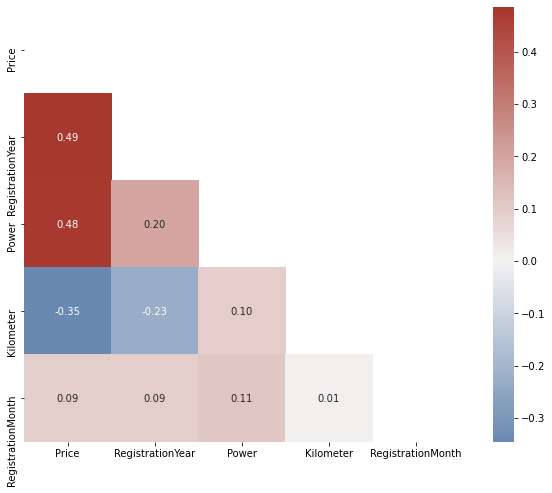

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap);

#### Наблюдаем небольшую корреляцию между ценой и мощностью автомобиля и отрицательную корреляцию между ценой и пробегом.

In [29]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

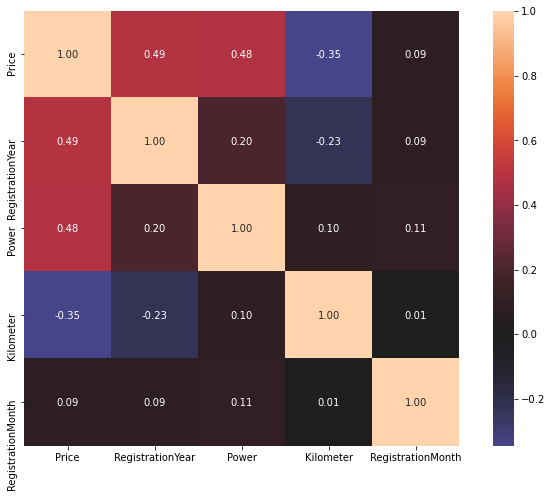

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, center=0, annot=True,
             fmt='.2f', square=True);

#### Приведем категориальные признаки для модели LinearRegression к количественным, методом one-hot encoding

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275357 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              275357 non-null  int64 
 1   VehicleType        275357 non-null  object
 2   RegistrationYear   275357 non-null  int64 
 3   Gearbox            275357 non-null  object
 4   Power              275357 non-null  int64 
 5   Model              275357 non-null  object
 6   Kilometer          275357 non-null  int64 
 7   RegistrationMonth  275357 non-null  int64 
 8   FuelType           275357 non-null  object
 9   Brand              275357 non-null  object
 10  NotRepaired        275357 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.2+ MB


In [29]:
categorial = ['VehicleType', 'Gearbox', 'Brand', 'FuelType', 'NotRepaired']

In [30]:
data_encoded = pd.get_dummies(data, drop_first=True, columns=categorial)

In [32]:
data_encoded['Model'].nunique()

250

#### Преобразуем признак @Model в количественный методом LabelEncoding, т.к в нем большое количество значений

In [33]:
l_encoder = LabelEncoder()

In [34]:
data_encoded['Model'] = l_encoder.fit_transform(data_encoded['Model'].values.reshape(-1, 1))

In [35]:
data_encoded

,Price,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_volvo,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_no,NotRepaired_yes
0,480,1993,0,117,150000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,2011,190,26,125000,5,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,9800,2004,163,118,125000,8,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1500,2001,75,117,150000,6,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,3600,2008,69,102,90000,7,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,2004,225,141,150000,5,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
354365,2200,2005,0,26,20000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354366,1199,2000,101,107,125000,3,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
354367,9200,1996,102,224,150000,3,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## Обучите разные модели. Для каждой попробуйте различные гиперпараметры.

#### Выделим  признаки. Проведем деление выборки на тренировочную и тестовую.

In [36]:
def get_features(data):
    
    X = data.drop('Price', axis=1)
    y = data['Price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2021)
    
    return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test = get_features(data_encoded)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((192749, 63), (82608, 63), (192749,), (82608,))

#### Для модели линейной регрессии выполним масштабирование признаков

In [39]:
scaler = StandardScaler()

In [40]:
scaler.fit(X_train)

StandardScaler()

In [41]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Создадим функцию для расчета метрики RMSE

In [42]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**.5

#### Создадим датафрейм для записи измерений времени

In [43]:
df_report = {
#     'wall_search_best_params': [],
    'wall_time_fit': [],
    'wall_time_predict': [],
    'rmse': []
}

#### Обучим модель линейной регресии и оценим качество.

In [44]:
%%time
#start time
start_time_lr_fit = time.time()

#fit
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

#end time
end_time_lr_fit = round(time.time() - start_time_lr_fit, 2)

Wall time: 891 ms


In [45]:
#start time
start_time_lr_pred = time.time()

#pred
y_pred_linreg = linreg.predict(X_test_scaled)

#end time
end_time_lr_pred = round(time.time() - start_time_lr_pred, 2)

RMSE_ = rmse(y_test, y_pred_linreg)

print('RMSE:', RMSE_)

RMSE: 2895.4373734427263


##### Подберем гиперпараметры для "деревянных"  моделей

### 1. DecisionTree

#### Будем оценивать модель с помощью  стратифицированной k-кратной кросс-валидации  k, равным 5. 

In [46]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [49]:
def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=2021)
    scores = cross_val_score(dt_model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    return scores

In [50]:
dt_model = DecisionTreeRegressor()

In [51]:
scores = evaluate_model(dt_model, X_train, y_train)

In [ ]:
-np.mean(scores)

#### Подберем лучшие гиперпараметры

In [52]:
decision_tree_params = {'min_samples_leaf': [5, 7, 9],
    'min_samples_split': [3, 5, 7],
    'max_depth' : [15, 17, 19, 21]}

In [53]:
cv = KFold(n_splits=10, shuffle=True, random_state=2021)

In [54]:
%%time

#start time
start_time_dt = time.time()

#search best parameters
clf_dt_randomsearch = RandomizedSearchCV(estimator=dt_model, param_distributions=decision_tree_params,  
                            cv=cv, scoring="neg_root_mean_squared_error",
                            n_jobs=-1, n_iter=5)

#end time
end_time_dt = round(time.time()- start_time_dt, 2)

Wall time: 0 ns


In [55]:
#start time
start_time_fit_dt = time.time()

#fit
clf_dt_randomsearch.fit(X_train, y_train)

#end time
end_time_fit_dt = round(time.time()- start_time_fit_dt, 2)

In [56]:
#start time
start_time_dt_pred = time.time()

#pred
y_pred_dt = clf_dt_randomsearch.predict(X_test)

#end time
end_time__dt_pred  = round(time.time() - start_time_dt_pred, 2)

In [57]:
RMSE_dt = rmse(y_test, y_pred_dt)

In [58]:
print('RMSE decision tree:', RMSE_dt)
print()
print('Best params decision tree with  RandomizedSearch:', clf_dt_randomsearch.best_params_)

RMSE decision tree: 1865.0416314204822

Best params decision tree with  RandomizedSearch: {'min_samples_split': 7, 'min_samples_leaf': 9, 'max_depth': 17}


In [65]:
%%time

clf_dt = GridSearchCV(estimator=dt_model, param_grid=decision_tree_params,  cv=cv,  
                   n_jobs=-1, scoring="neg_root_mean_squared_error")
clf_dt.fit(X_train, y_train)

Wall time: 2min 39s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [11, 13, 15, 17],
                         'min_samples_leaf': [11, 15, 19],
                         'min_samples_split': [3, 5, 7]},
             scoring='neg_root_mean_squared_error')

In [66]:
print('RMSE decision tree:', rmse(y_test, clf_dt.predict(X_test)))
print()
print('Best params decision tree with GridSearchCV:', clf_dt.best_params_)

RMSE decision tree: 1862.204327155886

Best params decision tree with GridSearchCV: {'max_depth': 17, 'min_samples_leaf': 11, 'min_samples_split': 7}


#### модель Дерева решений с применением поиска лучших параметров с помощью RandomizedSearchCV показывает метрику RMSE немного хуже с  RandomizedSearchCV, но при этом  поиск лучших параметров происходит в разы быстрее. Поэтому в дальнейшем будем использовать RandomizedSearch для поиска гиперпараметров.
#### RandomizedSearchCV лучше работает прибольшом количестве признаков.

### 2. RandomForestRegressor


In [59]:
random_f = RandomForestRegressor(random_state=2021)

In [444]:
cv = KFold(n_splits=10, shuffle=True, random_state=2021)

In [60]:
rf_params = {'max_depth': [15, 17, 19, 21],
            'n_estimators': range(1, 51, 10),
            'min_samples_leaf': [3, 5, 7]}

In [61]:
rf_grid = RandomizedSearchCV(estimator=random_f, param_distributions=rf_params,  
                            cv=cv, scoring="neg_root_mean_squared_error",
                            n_jobs=-1, n_iter=5)

In [62]:
%%time

rf_grid.fit(X_train, y_train)

Wall time: 12min 22s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=2021, shuffle=True),
                   estimator=RandomForestRegressor(random_state=2021), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [15, 17, 19, 21],
                                        'min_samples_leaf': [3, 5, 7],
                                        'n_estimators': range(1, 51, 10)},
                   scoring='neg_root_mean_squared_error')

In [63]:
rf_y_pred = rf_grid.predict(X_test)

In [64]:
print('RMSE Random Forest:', rmse(y_test, rf_y_pred))
print()
print('Best params Random Forest:', rf_grid.best_params_)

RMSE Random Forest: 1685.6695975615596

Best params Random Forest: {'n_estimators': 41, 'min_samples_leaf': 3, 'max_depth': 19}


In [451]:
#### Результат метрики RMSE для случайного леса значительно лучше, чем для дерева решений.

In [ ]:
#### Расчет с лучшими параметрами

In [65]:
rf_grid.best_params_

{'n_estimators': 41, 'min_samples_leaf': 3, 'max_depth': 19}

In [67]:
random_f_final = RandomForestRegressor(random_state=2021, **rf_grid.best_params_)

In [68]:
#start time
start_time_rf_fit = time.time()

#fit
random_f_final.fit(X_train, y_train)

#end time
end_time_rf_fit = round(time.time() - start_time_rf_fit, 2)

In [69]:
#start time
start_time_rf_pred = time.time()

#pred
rf_y_pred_final = random_f_final.predict(X_test)

#end time
end_time_rf_pred = round(time.time() - start_time_rf_pred, 2)

In [70]:
RMSE_rf = rmse(y_test, rf_y_pred)

In [71]:
print('RMSE Random Forest final:', rmse(y_test, rf_y_pred))

RMSE Random Forest final: 1685.6695975615596


### Подготовим данные для обучения LightGBM, Catboost, XGBoost 

In [75]:
## Данные для catboost, lightgbm. Т.к модель catboost позовляет сразу работать с категориальными признаками, не будем декодировать их в количественные
X_train_, X_test_, y_train_, y_test_ = get_features(data)

In [83]:
for col in categorial_col:
    X_train_[col] = X_train_[col].astype('category')
    X_test_[col] = X_test_[col].astype('category')

In [87]:
X_train_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192749 entries, 292189 to 117334
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        192749 non-null  category
 1   RegistrationYear   192749 non-null  int64   
 2   Gearbox            192749 non-null  category
 3   Power              192749 non-null  int64   
 4   Model              192749 non-null  category
 5   Kilometer          192749 non-null  int64   
 6   RegistrationMonth  192749 non-null  int64   
 7   FuelType           192749 non-null  category
 8   Brand              192749 non-null  category
 9   NotRepaired        192749 non-null  category
dtypes: category(6), int64(4)
memory usage: 8.7 MB


#### 1-стадия поиска гиперпараметров для модели lightGBM - настройка сложности

In [123]:
lgbm = LGBMRegressor(random_state=2021)

In [124]:
cv = KFold(n_splits=10, shuffle=True, random_state=2021)

In [125]:
params_grid = {'num_leaves': [7, 15, 31, 63], 
              'max_depth': [10, 15, 21]}

In [126]:
grid_searcher = RandomizedSearchCV(estimator=lgbm, param_distributions=params_grid,
                             scoring='neg_root_mean_squared_error',
                             cv=cv, verbose=5, n_jobs=-1, n_iter=10, random_state=2021)

In [282]:
%%time

grid_searcher.fit(X_train_, y_train_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 19 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
                   estimator=LGBMRegressor(random_state=2021), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 15, 21],
                                        'num_leaves': [7, 15, 31, 63]},
                   random_state=2021, scoring='neg_root_mean_squared_error',
                   verbose=5)

In [283]:
print('Best params decision tree with GridSearchCV:', grid_searcher.best_params_)

Best params decision tree with GridSearchCV: {'num_leaves': 63, 'max_depth': 15}


In [284]:
print('RMSE LightGBM tuning params:', rmse(y_test_, grid_searcher.predict(X_test_)))

RMSE LightGBM tuning params: 1618.875385867793


#### Второй этап поиска лучших гиперпараметров. Поиск шага обучения

In [285]:
num_iter = 200

In [287]:
lgbm2 = LGBMRegressor(max_depth=15, num_leaves=63,
                      n_estimators=num_iter, random_state=2021,
                      n_jobs=-1)

In [288]:
grid_params2 = {'learning_rate': [0.01, 0.1, 0.15, 0.2]}

In [289]:
grid_searcher2 = RandomizedSearchCV(estimator=lgbm2, param_distributions=grid_params2,
                             scoring='neg_root_mean_squared_error',
                             cv=cv_lgbm, verbose=5, n_jobs=-1, n_iter=5, random_state=2021)

In [290]:
%%time

grid_searcher2.fit(X_train_, y_train_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Wall time: 28.3 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
                   estimator=LGBMRegressor(max_depth=15, n_estimators=200,
                                           num_leaves=63, random_state=2021),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.15,
                                                          0.2]},
                   random_state=2021, scoring='neg_root_mean_squared_error',
                   verbose=5)

In [292]:
print('Best params decision tree with GridSearchCV:', grid_searcher2.best_params_)

Best params decision tree with GridSearchCV: {'learning_rate': 0.15}


In [293]:
print('RMSE LightGBM tuning params2:', rmse(y_test_, grid_searcher2.predict(X_test_)))

RMSE LightGBM tuning params2: 1596.8000915307025


#### Финальный расчет LightGBM.

In [296]:
final_lgbm = LGBMRegressor(max_depth=15, num_leaves=63,
                      n_estimators=200, learning_rate=0.15, 
                      random_state=2021, 
                      n_jobs=-1)

In [297]:
%%time

final_lgbm.fit(X_train_, y_train_)

Wall time: 1.37 s


LGBMRegressor(learning_rate=0.15, max_depth=15, n_estimators=200, num_leaves=63,
              random_state=2021)

In [298]:
print('RMSE LightGBM final:', rmse(y_test_, final_lgbm.predict(X_test_)))

RMSE LightGBM final: 1596.8000915307025


#### Поиск гиперпараметров без разбиения на этапы.

In [90]:
num_iter = 200

In [91]:
%%time

lgbm = LGBMRegressor(random_state=2021, n_estimators=num_iter)

params_lgbm = {'num_leaves': [7, 15, 31, 63], 
              'max_depth': [10, 15, 21],
              'learning_rate': [0.01, 0.1, 0.15, 0.2],
}

search_cv = RandomizedSearchCV(estimator=lgbm, 
                  param_distributions=params_lgbm,
                  scoring='neg_root_mean_squared_error',
                  n_iter=num_iter, n_jobs=-1, random_state=2021)

Wall time: 0 ns


In [93]:
%%time

search_cv.fit(X_train_, y_train_)

Wall time: 4min 15s


RandomizedSearchCV(estimator=LGBMRegressor(n_estimators=200, random_state=2021),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.15, 0.2],
                                        'max_depth': [10, 15, 21],
                                        'num_leaves': [7, 15, 31, 63]},
                   random_state=2021, scoring='neg_root_mean_squared_error')

In [94]:
search_cv.best_params_

{'num_leaves': 63, 'max_depth': 10, 'learning_rate': 0.1}

In [95]:
%%time

y_lgbm_pred = search_cv.predict(X_test_)

Wall time: 658 ms


In [216]:
#### Расчитаем метрику RMSE на модели с лучшими гиперпараметрами.

In [96]:
%%time

lgbm_m = LGBMRegressor(random_state=2021, n_estimators=num_iter).set_params(**search_cv.best_params_)

#start time
start_time_lgbm_fit = time.time()

#fit
lgbm_m.fit(X_train_, y_train_)

#end time
end_time_lgbm_fit = round(time.time() - start_time_lgbm_fit, 2)

Wall time: 1.47 s


In [97]:
#start time
start_time_lgbm_pred = time.time()

#predict
y_pred_lgbm = lgbm_m.predict(X_test_)

#end time
end_time_lgbm_pred = round(time.time() - start_time_lgbm_pred, 2)

In [98]:
RMSE_lgbm_ = rmse(y_test_, y_pred_lgbm)

In [99]:
print('RMSE LightGBM :', RMSE_lgbm_)

RMSE LightGBM : 1600.339197716536


In [180]:
#### Модель LightGBM c поэтапным поиском гиперпараметров показала лучший результат по метрике RMSE

#### Посмотрим какие прараметры внесли наибольшее влияние на расчет метрики

In [100]:
importance_feature = pd.DataFrame(lgbm_m.feature_importances_,
             index=X_train_.columns, columns=['Importance']).sort_values(
    by='Importance', ascending=False)

In [101]:
importance_feature

,Importance
RegistrationYear,2779
Power,2588
Model,2346
Kilometer,1197
Brand,921
RegistrationMonth,779
VehicleType,714
NotRepaired,476
Gearbox,370
FuelType,205


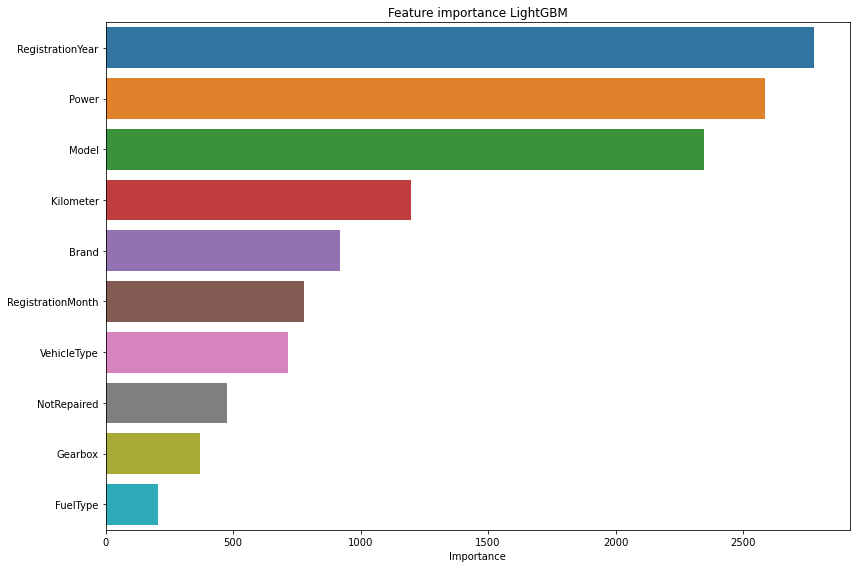

In [102]:
plt.figure(figsize=(12, 8))

sns.barplot(y=importance_feature.index, 
            x='Importance', 
            data=importance_feature)
plt.title('Feature importance LightGBM');
plt.tight_layout()
plt.show()

#### Важность признаков определятся на основе того какой суммарный прирост информации (IG) дает разбиение по признаку  и как часто использовалтся признак при разбиении дерева.
#### Feature importance можно использовать как инструмент для дальнейшего улучшения качеств модели за счет исключения признаков вносящих минимальный вклад в модель. 
#### Также выявление наиболее важных признаков может помочь в определении и генерации новых признаков для улучшения качества модели.


### 2. Catboost

In [104]:
from catboost import CatBoostRegressor, Pool, cv

In [110]:
catb = CatBoostRegressor(verbose=5, early_stopping_rounds=20, eval_metric='RMSE',
                        random_seed=2021)

In [111]:
catb.get_params()

{'loss_function': 'RMSE',
 'random_seed': 2021,
 'verbose': 5,
 'eval_metric': 'RMSE',
 'early_stopping_rounds': 20}

In [112]:
cv = KFold(n_splits=10, shuffle=True, random_state=2021)

In [113]:
catboost_params1 = {'max_depth': [10, 12, 14, 16], 
                  'iterations': [150], 
                  'learning_rate': [0.1, 0.15, 0.2, 0.3]
                   }
#                    'loss_function': "RMSE"}

In [594]:
#Попытка выполнить расчет с использование встроенных методов CV и randomized_search
# cv_dataset = Pool(data=X_train_,
#                   label=y_train_,
#                   cat_features=categorial_col)

In [566]:
# cv_cat = cv(cv_dataset,
#             catboost_params1,
#             fold_count=5,
#             shuffle=True,
#             plot="True")

In [567]:

# catboost_params2 = {'learning_rate': np.logspace(-1, 0, 10)}

In [568]:
#### Поиск лучших параметров. Воспользуемся всстроенным методом библиотеки Catboost - grid_search

In [149]:
# %%time

# catb_grid1 = catb.randomized_search(catboost_params1, 
#                         cv_dataset,
#                         cv=cv_cat, 
#                         plot=True)

In [150]:
# catb_grid1.get('params')

In [151]:
# catb2 = CatBoostRegressor(max_depth=15, iterations=200,
#     verbose=5, early_stopping_rounds=10, eval_metric='RMSE',
#     random_seed=2021)

In [152]:
# catb_grid2 = catb.grid_search(catboost_params2, 
#                         X=X_train, 
#                         y=y_train,
#                         cv=cv_cat, 
#                         plot=True)

In [153]:
# catb_final = CatBoostRegressor(max_depth=15, iterations=200, learning_rate=0.16681005372000587,
#     verbose=5, early_stopping_rounds=10, eval_metric='RMSE',
#     random_seed=2021)

In [154]:
# catb_final.fit(X_train_, y_train_, cat_features)

In [155]:
# y_pred_cat = catb_final.predict(X_test_)

In [156]:
# print('RMSE Catboost :', rmse(y_test_, y_pred_cat))

#### Подберем лучшие параметры встроенным методом randomized_search библиотеки Catboost

In [115]:
train_pool = Pool(X_train_, y_train_, cat_features=categorial_col)
test_pool = Pool(X_test_, y_test_, cat_features=categorial_col)

In [116]:
%%time

n_iterations = 100 
catb_grid = catb.randomized_search(catboost_params1, 
                        train_pool,
                        n_iter=n_iterations,
                        search_by_train_test_split=False,
                        cv=cv,
                        early_stopping_rounds=20,
                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5971.7968599	test: 5964.5293251	best: 5964.5293251 (0)	total: 133ms	remaining: 19.8s
5:	learn: 4029.3325992	test: 4024.7953519	best: 4024.7953519 (5)	total: 468ms	remaining: 11.2s
10:	learn: 2998.0092656	test: 2991.2144507	best: 2991.2144507 (10)	total: 787ms	remaining: 9.95s
15:	learn: 2470.1845192	test: 2458.9022145	best: 2458.9022145 (15)	total: 1.09s	remaining: 9.11s
20:	learn: 2181.0139375	test: 2166.4112934	best: 2166.4112934 (20)	total: 1.39s	remaining: 8.54s
25:	learn: 2021.7043977	test: 2003.6056071	best: 2003.6056071 (25)	total: 1.7s	remaining: 8.13s
30:	learn: 1938.6631538	test: 1920.9649693	best: 1920.9649693 (30)	total: 2.01s	remaining: 7.73s
35:	learn: 1881.4065125	test: 1866.4425047	best: 1866.4425047 (35)	total: 2.31s	remaining: 7.32s
40:	learn: 1848.2081958	test: 1834.4249888	best: 1834.4249888 (40)	total: 2.6s	remaining: 6.92s
45:	learn: 1824.3371770	test: 1812.8460425	best: 1812.8460425 (45)	total: 2.92s	remaining: 6.61s
50:	learn: 1805.5841210	test: 1795.8

100:	learn: 1576.0461786	test: 1644.3245591	best: 1644.3153675 (99)	total: 6.66s	remaining: 3.23s
105:	learn: 1570.8559451	test: 1642.3402895	best: 1642.3402895 (105)	total: 6.95s	remaining: 2.88s
110:	learn: 1563.6929116	test: 1638.3949113	best: 1638.3949113 (110)	total: 7.24s	remaining: 2.54s
115:	learn: 1559.1861093	test: 1637.2336817	best: 1637.2336817 (115)	total: 7.53s	remaining: 2.21s
120:	learn: 1554.4365727	test: 1636.1487223	best: 1636.1487223 (120)	total: 7.83s	remaining: 1.88s
125:	learn: 1549.6974766	test: 1635.3291635	best: 1635.2525381 (123)	total: 8.16s	remaining: 1.55s
130:	learn: 1547.3478389	test: 1634.5095651	best: 1634.5095651 (130)	total: 8.45s	remaining: 1.23s
135:	learn: 1542.1000844	test: 1632.9826290	best: 1632.9826290 (135)	total: 8.74s	remaining: 900ms
140:	learn: 1537.7435740	test: 1631.6151303	best: 1631.6151303 (140)	total: 9.03s	remaining: 577ms
145:	learn: 1533.2894476	test: 1630.1164611	best: 1630.1164611 (145)	total: 9.32s	remaining: 255ms
149:	learn:

40:	learn: 1710.6475681	test: 1729.8840337	best: 1729.8840337 (40)	total: 3.41s	remaining: 9.06s
45:	learn: 1695.9273799	test: 1721.0894702	best: 1721.0894702 (45)	total: 3.78s	remaining: 8.55s
50:	learn: 1680.5424096	test: 1710.6454925	best: 1710.6454925 (50)	total: 4.16s	remaining: 8.07s
55:	learn: 1669.4858149	test: 1703.6355093	best: 1703.6355093 (55)	total: 4.52s	remaining: 7.59s
60:	learn: 1656.6470561	test: 1695.2520249	best: 1695.2520249 (60)	total: 4.89s	remaining: 7.13s
65:	learn: 1644.9319714	test: 1688.2309287	best: 1688.2309287 (65)	total: 5.26s	remaining: 6.69s
70:	learn: 1636.7799209	test: 1683.3992703	best: 1683.3992703 (70)	total: 5.62s	remaining: 6.25s
75:	learn: 1625.9664758	test: 1677.7719238	best: 1677.7719238 (75)	total: 5.99s	remaining: 5.83s
80:	learn: 1615.9186887	test: 1669.7683759	best: 1669.7683759 (80)	total: 6.4s	remaining: 5.45s
85:	learn: 1604.3955264	test: 1663.1611469	best: 1663.1611469 (85)	total: 6.82s	remaining: 5.08s
90:	learn: 1593.3023615	test: 1

140:	learn: 1411.7681210	test: 1622.1070705	best: 1622.0258477 (137)	total: 11.3s	remaining: 719ms
145:	learn: 1403.6069912	test: 1620.1933718	best: 1620.1933718 (145)	total: 11.6s	remaining: 319ms
149:	learn: 1400.2696191	test: 1619.7379307	best: 1619.7379307 (149)	total: 11.9s	remaining: 0us

bestTest = 1619.737931
bestIteration = 149

7:	loss: 1619.7379307	best: 1617.0387412 (6)	total: 1m 25s	remaining: 1m 25s
0:	learn: 5969.7277012	test: 5962.6321392	best: 5962.6321392 (0)	total: 159ms	remaining: 23.7s
5:	learn: 4003.5573998	test: 4001.5697781	best: 4001.5697781 (5)	total: 874ms	remaining: 21s
10:	learn: 2940.5969229	test: 2941.1759005	best: 2941.1759005 (10)	total: 1.64s	remaining: 20.7s
15:	learn: 2394.7630202	test: 2394.5618241	best: 2394.5618241 (15)	total: 2.36s	remaining: 19.8s
20:	learn: 2073.3163995	test: 2076.1636258	best: 2076.1636258 (20)	total: 3.18s	remaining: 19.5s
25:	learn: 1902.9525708	test: 1908.6432891	best: 1908.6432891 (25)	total: 3.89s	remaining: 18.6s
30:	lea

80:	learn: 1417.8110446	test: 1629.0089503	best: 1629.0089503 (80)	total: 11.9s	remaining: 10.1s
85:	learn: 1406.1737859	test: 1628.1538269	best: 1628.1538269 (85)	total: 12.8s	remaining: 9.5s
90:	learn: 1394.6380984	test: 1627.3556437	best: 1627.3556437 (90)	total: 13.6s	remaining: 8.82s
95:	learn: 1382.9923314	test: 1627.0407715	best: 1627.0080579 (93)	total: 14.3s	remaining: 8.06s
100:	learn: 1374.8723122	test: 1625.4070602	best: 1625.4070602 (100)	total: 15.1s	remaining: 7.31s
105:	learn: 1365.7780331	test: 1623.5060810	best: 1623.5060810 (105)	total: 15.7s	remaining: 6.52s
110:	learn: 1354.6862048	test: 1623.8143922	best: 1623.5060810 (105)	total: 16.6s	remaining: 5.83s
115:	learn: 1346.2368626	test: 1623.4014792	best: 1623.1764875 (113)	total: 17.3s	remaining: 5.07s
120:	learn: 1338.9244064	test: 1622.1376451	best: 1622.1376451 (120)	total: 18.1s	remaining: 4.33s
125:	learn: 1330.4809878	test: 1621.7782701	best: 1621.7298126 (122)	total: 18.8s	remaining: 3.58s
130:	learn: 1323.41

20:	learn: 1771.5086915	test: 1814.0217842	best: 1814.0217842 (20)	total: 7.66s	remaining: 47.1s
25:	learn: 1688.0040659	test: 1744.3760188	best: 1744.3760188 (25)	total: 9.63s	remaining: 45.9s
30:	learn: 1633.1180129	test: 1713.1889563	best: 1713.1889563 (30)	total: 11.6s	remaining: 44.4s
35:	learn: 1602.6610027	test: 1696.6322251	best: 1696.6322251 (35)	total: 13.5s	remaining: 42.9s
40:	learn: 1575.1740213	test: 1686.0728488	best: 1686.0728488 (40)	total: 15.6s	remaining: 41.4s
45:	learn: 1553.9233060	test: 1675.1758111	best: 1675.1758111 (45)	total: 17.8s	remaining: 40.1s
50:	learn: 1532.7718961	test: 1667.8696396	best: 1667.8696396 (50)	total: 19.9s	remaining: 38.6s
55:	learn: 1513.6483533	test: 1662.6500645	best: 1662.6500645 (55)	total: 22.1s	remaining: 37.1s
60:	learn: 1491.9012642	test: 1651.8969207	best: 1651.8969207 (60)	total: 24.3s	remaining: 35.4s
65:	learn: 1474.3252328	test: 1645.3772729	best: 1645.3772729 (65)	total: 26.3s	remaining: 33.4s
70:	learn: 1461.0241461	test: 

135:	learn: 1140.4452844	test: 1628.8709363	best: 1628.5152175 (127)	total: 59.5s	remaining: 6.12s
140:	learn: 1131.6298952	test: 1628.8407440	best: 1628.4376743 (139)	total: 1m 1s	remaining: 3.94s
145:	learn: 1123.3555491	test: 1629.6785067	best: 1628.4376743 (139)	total: 1m 3s	remaining: 1.74s
149:	learn: 1115.1499336	test: 1629.1862016	best: 1628.4376743 (139)	total: 1m 5s	remaining: 0us

bestTest = 1628.437674
bestIteration = 139

15:	loss: 1628.4376743	best: 1611.9222987 (13)	total: 6m 55s	remaining: 0us
Estimating final quality...
0:	learn: 5685.0544330	test: 5685.4537801	best: 5685.4537801 (0)	total: 6.74s	remaining: 16m 44s
5:	learn: 3225.3604888	test: 3231.8283082	best: 3231.8283082 (5)	total: 38.3s	remaining: 15m 19s
10:	learn: 2296.8669887	test: 2315.5219581	best: 2315.5219581 (10)	total: 1m 11s	remaining: 15m
15:	learn: 1911.1011429	test: 1946.6872525	best: 1946.6872525 (15)	total: 1m 45s	remaining: 14m 40s
20:	learn: 1765.4923862	test: 1820.2104693	best: 1820.2104693 (20)	

In [117]:
catb_grid.get('params')

{'depth': 14, 'iterations': 150, 'learning_rate': 0.15}

In [133]:
cboost = CatBoostRegressor(verbose=5, 
                           early_stopping_rounds=20, 
                           eval_metric='RMSE',
                           random_seed=2021, 
                           use_best_model=True, 
                           max_depth=catb_grid.get('params')['depth'],
                           iterations=catb_grid.get('params')['iterations'],
                           learning_rate=catb_grid.get('params')['learning_rate'])

In [134]:
%%time

#start time
start_time_cat_fit = time.time()

#fit
cboost.fit(train_pool, 
              eval_set=[(X_test_, y_test_)],
              plot=True)

#end time
end_time_cat_fit = round(time.time() - start_time_cat_fit, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4069.9774144	test: 4081.0697816	best: 4081.0697816 (0)	total: 485ms	remaining: 1m 12s
5:	learn: 2642.5379387	test: 2655.3536088	best: 2655.3536088 (5)	total: 2.95s	remaining: 1m 10s
10:	learn: 2067.6831924	test: 2095.5500027	best: 2095.5500027 (10)	total: 5.2s	remaining: 1m 5s
15:	learn: 1826.3226226	test: 1872.1202251	best: 1872.1202251 (15)	total: 7.53s	remaining: 1m 3s
20:	learn: 1722.7555655	test: 1784.3182303	best: 1784.3182303 (20)	total: 9.84s	remaining: 1m
25:	learn: 1656.9642694	test: 1738.5153046	best: 1738.5153046 (25)	total: 12.3s	remaining: 58.5s
30:	learn: 1617.1222160	test: 1716.7835474	best: 1716.7835474 (30)	total: 14.6s	remaining: 56.1s
35:	learn: 1589.6229447	test: 1701.3840012	best: 1701.3840012 (35)	total: 16.9s	remaining: 53.6s
40:	learn: 1570.0515938	test: 1689.8948124	best: 1689.8948124 (40)	total: 19.3s	remaining: 51.2s
45:	learn: 1546.9238714	test: 1683.3038376	best: 1683.3038376 (45)	total: 21.6s	remaining: 48.9s
50:	learn: 1531.5847705	test: 1678.2

In [135]:
%%time

#start time
start_time_cat_pred = time.time()

#pred
catb_y_pred = cboost.predict(X_test_)

#end time
end_time_cat_pred = round(time.time() - start_time_cat_pred, 2)

Wall time: 147 ms


In [136]:
RMSE_catboost = rmse(y_test_, catb_y_pred)

In [137]:
print('RMSE Catboost :', RMSE_catboost)

RMSE Catboost : 1630.081601801201


#### Попробуем использовать catboost без настройки гиперпараметров.

In [138]:
catboost_default = CatBoostRegressor(verbose=5, random_seed=2021)

In [145]:
%%time
#start time
start_time_cat_def_fit = time.time()

catboost_default.fit(train_pool, early_stopping_rounds=100)

#end time
end_time_cat_def_fit = round(time.time() - start_time_cat_fit, 2)

Learning rate set to 0.09957
0:	learn: 4268.1389172	total: 147ms	remaining: 2m 27s
5:	learn: 3219.5916375	total: 851ms	remaining: 2m 20s
10:	learn: 2649.0238218	total: 1.57s	remaining: 2m 21s
15:	learn: 2335.3104034	total: 2.24s	remaining: 2m 17s
20:	learn: 2147.9398120	total: 2.87s	remaining: 2m 13s
25:	learn: 2039.3187485	total: 3.49s	remaining: 2m 10s
30:	learn: 1971.5836477	total: 4.13s	remaining: 2m 9s
35:	learn: 1929.9852168	total: 4.75s	remaining: 2m 7s
40:	learn: 1894.9051579	total: 5.42s	remaining: 2m 6s
45:	learn: 1871.8334141	total: 6.06s	remaining: 2m 5s
50:	learn: 1852.2649144	total: 6.81s	remaining: 2m 6s
55:	learn: 1835.1880161	total: 7.48s	remaining: 2m 6s
60:	learn: 1821.4901544	total: 8.08s	remaining: 2m 4s
65:	learn: 1810.8236542	total: 8.72s	remaining: 2m 3s
70:	learn: 1799.9319788	total: 9.39s	remaining: 2m 2s
75:	learn: 1791.4511220	total: 10.1s	remaining: 2m 2s
80:	learn: 1784.7347526	total: 10.7s	remaining: 2m 1s
85:	learn: 1774.0927477	total: 11.4s	remaining: 2

740:	learn: 1553.9090078	total: 1m 42s	remaining: 35.8s
745:	learn: 1553.3469381	total: 1m 43s	remaining: 35.1s
750:	learn: 1552.8583852	total: 1m 43s	remaining: 34.4s
755:	learn: 1552.3932800	total: 1m 44s	remaining: 33.7s
760:	learn: 1551.9363728	total: 1m 45s	remaining: 33s
765:	learn: 1551.5997687	total: 1m 45s	remaining: 32.4s
770:	learn: 1551.0129625	total: 1m 46s	remaining: 31.7s
775:	learn: 1550.5007001	total: 1m 47s	remaining: 31s
780:	learn: 1549.9638977	total: 1m 48s	remaining: 30.3s
785:	learn: 1549.2434624	total: 1m 48s	remaining: 29.7s
790:	learn: 1548.7843868	total: 1m 49s	remaining: 29s
795:	learn: 1548.2792015	total: 1m 50s	remaining: 28.3s
800:	learn: 1547.9562924	total: 1m 51s	remaining: 27.6s
805:	learn: 1547.1091927	total: 1m 51s	remaining: 26.9s
810:	learn: 1546.5863787	total: 1m 52s	remaining: 26.2s
815:	learn: 1546.1871220	total: 1m 53s	remaining: 25.5s
820:	learn: 1545.7675225	total: 1m 53s	remaining: 24.8s
825:	learn: 1545.1993178	total: 1m 54s	remaining: 24.1

In [146]:
#start time
start_time_cat_def_pred = time.time()

cat_pred_default = catboost_default.predict(X_test_)

#end time
end_time_cat_def_pred = round(time.time() - start_time_cat_pred, 2)

In [147]:
RMSE_catboost_def = rmse(y_test_, cat_pred_default)
RMSE_catboost_def

1624.0434053927167

#### Получили метрику RMSE на модели по-умолчанию лучше, чем с настроенными гиперпараметрами. Можно было продолжить поиск параметров, но из-за сильно ограниченных ресурсов  ПК решено оставить их в текущем виде.

### Построим график важности признаков

In [148]:
catboost_default.get_feature_importance(data=train_pool,
                       prettified=False,
                       verbose=False)

array([ 7.42634254, 40.68535163,  0.79949853, 26.05969901,  4.54458088,
        6.03291786,  0.29116059,  1.51217809,  9.65091903,  2.99735184])

In [149]:
cat_feature_importance = pd.DataFrame({'feature_importance': catboost_default.get_feature_importance(train_pool), 
              'feature_names': X_train_.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
cat_feature_importance

,feature_importance,feature_names
1,40.685352,RegistrationYear
3,26.059699,Power
8,9.650919,Brand
0,7.426343,VehicleType
5,6.032918,Kilometer
4,4.544581,Model
9,2.997352,NotRepaired
7,1.512178,FuelType
2,0.799499,Gearbox
6,0.291161,RegistrationMonth


Text(41.5, 0.5, 'Feature names')

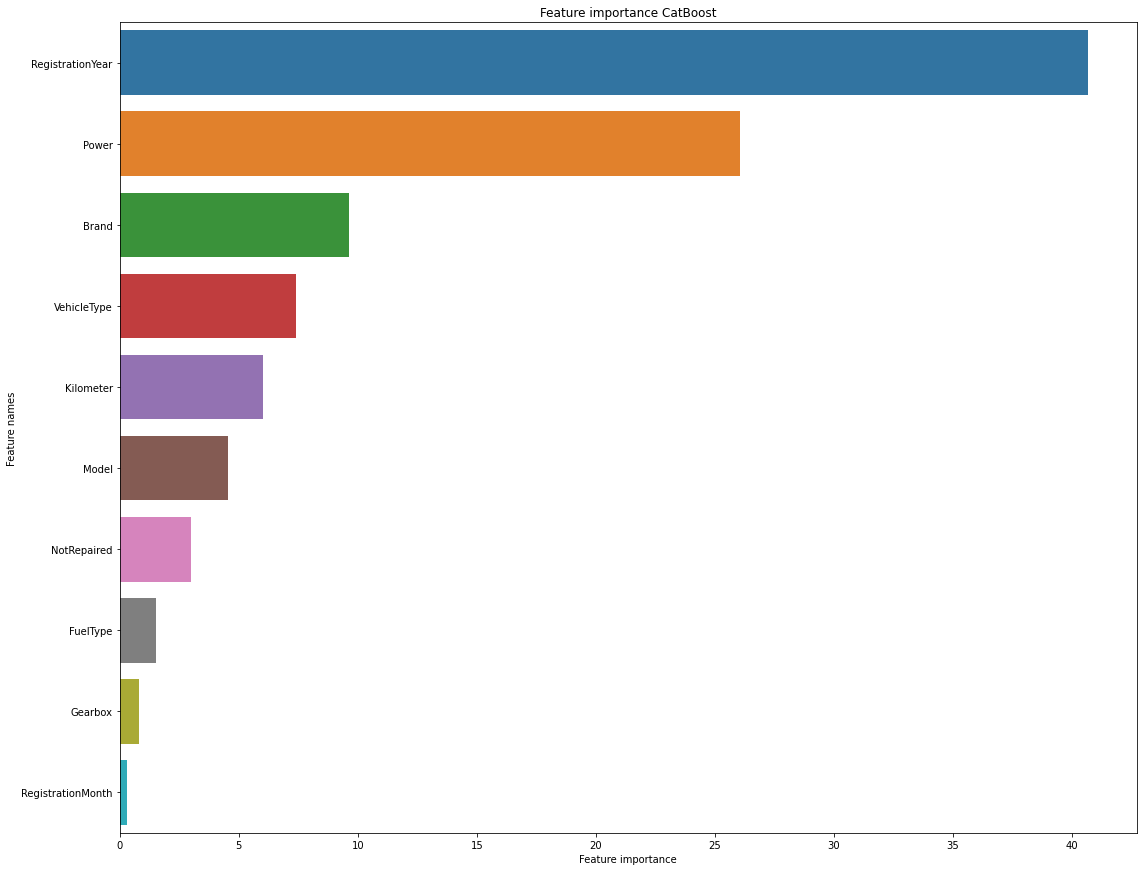

In [150]:
plt.figure(figsize=(16,12))

sns.barplot(x=cat_feature_importance['feature_importance'], 
            y=cat_feature_importance['feature_names'], 
            data=cat_feature_importance)

plt.tight_layout()
plt.title('Feature importance CatBoost')
plt.xlabel('Feature importance')
plt.ylabel('Feature names')

### 3. XGBoost

In [192]:
import time
import xgboost as xgb

In [195]:
%%time

clf = xgb.XGBRegressor(eval_metric="rmse")

parameters = {
     "eta"    : [0.01, 0.10, 0.20],
     "max_depth"        : [10, 12, 15],
     "min_child_weight" : [3, 5, 7]
     }

cv = KFold(random_state=2021, shuffle=True)

grid_xgb = RandomizedSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_root_mean_squared_error",
                    cv=cv,
                    random_state=2021)

Wall time: 0 ns


In [ ]:
%%time

grid_xgb.fit(X_train, y_train,
            early_stopping_rounds=20,
            eval_set=[(X_test, y_test)]
    )

In [189]:
### Записываем гиперпараметры в отдельную переменную
best_params = grid_xgb.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [177]:
clf_xgb = xgb.XGBRegressor(eval_metric="rmse"                          
                          ).set_params(**best_params)

In [178]:
%%time

#start time
start_time_xgb_fit= time.time()

#fit
clf_xgb.fit(X_train, y_train,
            early_stopping_rounds=20,
            eval_set=[(X_train, y_train), (X_test, y_test)]
    )

#end time
end_time_xgb_fit = round(time.time() - start_time_xgb_fit, 2)

[0]	validation_0-rmse:5349.71143	validation_1-rmse:5363.25586
[1]	validation_0-rmse:4431.88379	validation_1-rmse:4452.28711
[2]	validation_0-rmse:3719.07788	validation_1-rmse:3747.38355
[3]	validation_0-rmse:3168.75928	validation_1-rmse:3205.61499
[4]	validation_0-rmse:2745.86816	validation_1-rmse:2794.62476
[5]	validation_0-rmse:2423.46265	validation_1-rmse:2484.02344
[6]	validation_0-rmse:2186.72070	validation_1-rmse:2260.21655
[7]	validation_0-rmse:2013.43811	validation_1-rmse:2098.57080
[8]	validation_0-rmse:1882.82861	validation_1-rmse:1979.65820
[9]	validation_0-rmse:1785.34949	validation_1-rmse:1894.16943
[10]	validation_0-rmse:1715.80176	validation_1-rmse:1834.35254
[11]	validation_0-rmse:1663.05432	validation_1-rmse:1790.33643
[12]	validation_0-rmse:1624.98547	validation_1-rmse:1760.48120
[13]	validation_0-rmse:1594.69995	validation_1-rmse:1737.25879
[14]	validation_0-rmse:1569.84375	validation_1-rmse:1720.01392
[15]	validation_0-rmse:1551.89636	validation_1-rmse:1707.53882
[1

In [179]:
%%time

#start time
start_time_xgb_pred = time.time()

#pred
y_xgb_predict = clf_xgb.predict(X_test)

#end time
end_time_xgb_pred = round(time.time() - start_time_xgb_pred, 2)

Wall time: 215 ms


In [180]:
RMSE_xgb = rmse(y_test, y_xgb_predict)

In [181]:
print('RMSE XGBoost :', RMSE_xgb)

RMSE XGBoost : 1618.697059218104


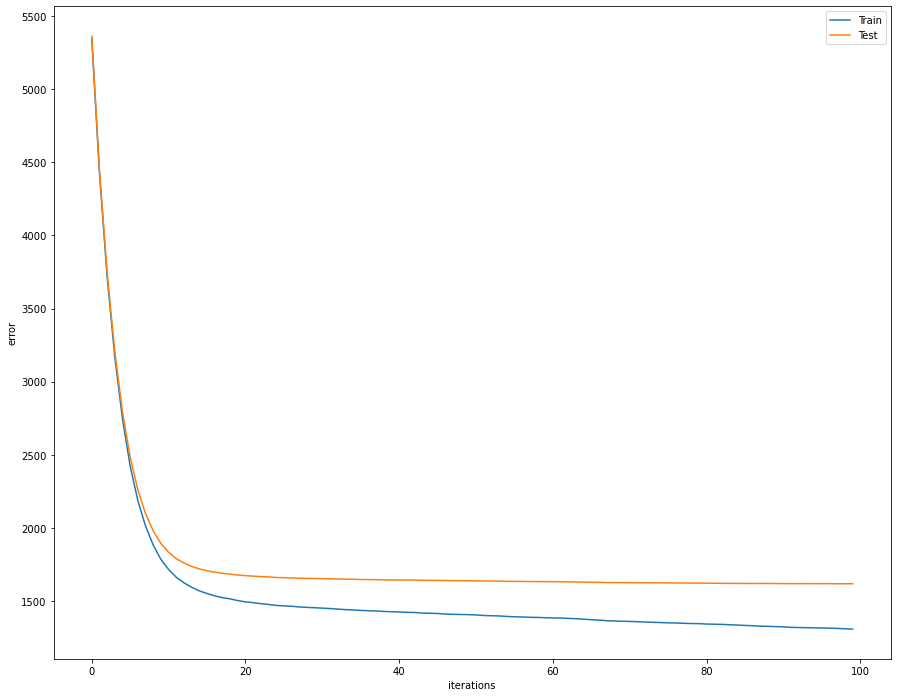

In [182]:
### Кривая обучения

plt.plot(clf_xgb.evals_result()["validation_0"]["rmse"], label='Train')
plt.plot(clf_xgb.evals_result()["validation_1"]["rmse"], label='Test')
plt.legend()
plt.xlabel("iterations")
plt.ylabel("error");

#### F score при оценке важности признаков в Xgboost вычисляется на основе того, как часто разбиение делалось по данному признаку.

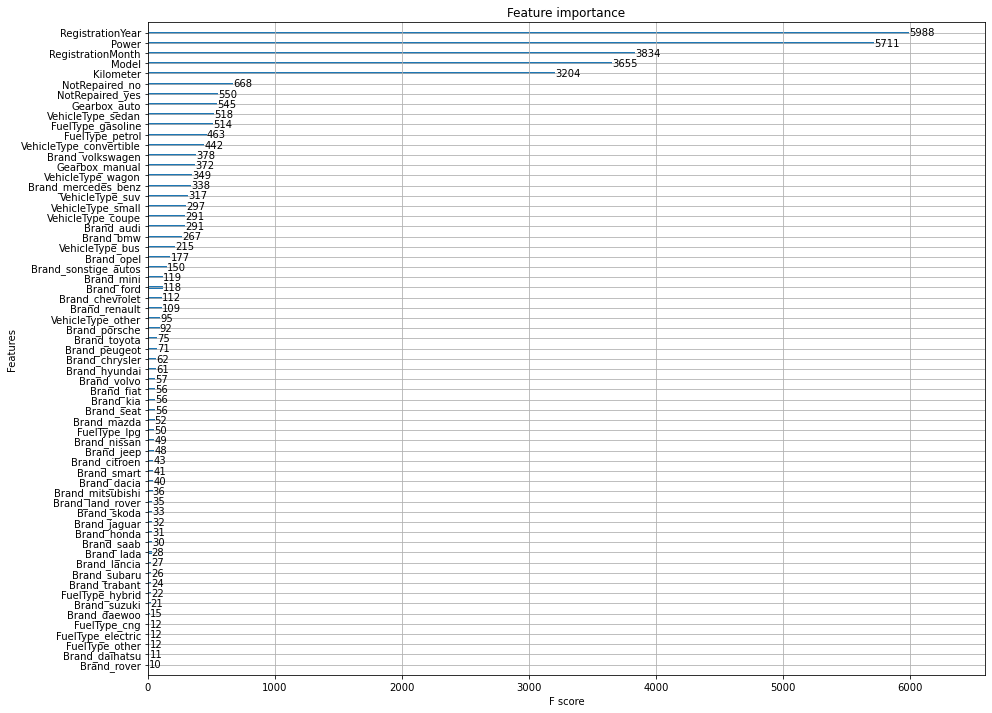

In [183]:
xgb.plot_importance(clf_xgb);

#### Странно, что важным параметром оказался месяц регистрации

### Расчет модели XGBoost используя 2-этапный поиск гиперпараметров c использованием объектов DMatrix для оптимизации времени поиска.

In [184]:
%%time

clf = xgb.XGBRegressor(eval_metric="rmse")

parameters = {
     "eta"    : [0.01, 0.10, 0.20],
     "max_depth"        : [10, 12, 15],
     "min_child_weight" : [3, 5, 7]
     }

cv = KFold(random_state=2021, shuffle=True)

grid_xgb = RandomizedSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_root_mean_squared_error",
                    cv=cv)

Wall time: 0 ns


In [185]:
xgb_train = xgb.DMatrix(data=X_train, label=y_train) # позволяет снизить время на обучении и меньше нагружать память
xgb_test = xgb.DMatrix(data=X_test, label=y_test) # позволяет снизить время на обучении и меньше нагружать память

In [188]:
grid_xgb

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          eval_metric='rmse', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_we...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                         

#### Построим кривую обучения

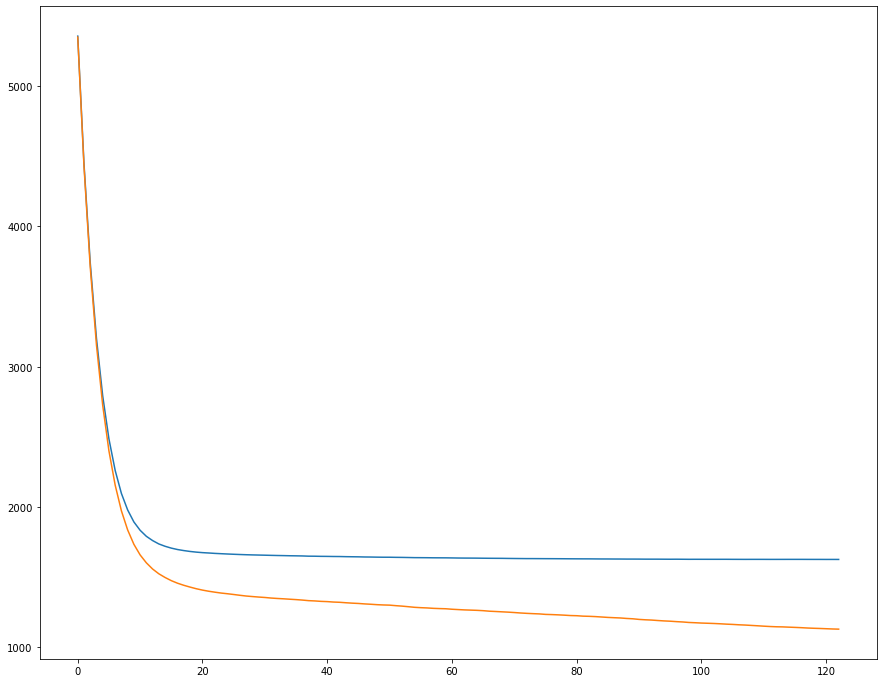

In [366]:
plt.plot(range(xgb_cv.shape[0]), xgb_cv["test-rmse-mean"])
plt.plot(range(xgb_cv.shape[0]), xgb_cv["train-rmse-mean"]);

#### Второй этап. Поиск оптимального количества итераций. 

In [367]:
best_num_round = np.argmin(xgb_cv["test-rmse-mean"]) #Находим минимальное количество итераций
best_num_round

122

In [368]:
num_boost_round=best_num_round

In [369]:
# watchlist нужен для отслеживания качества модели. Отслеживать будем по тренировочной и тестовой выборке
watchlist = [(xgb_train, 'train'), (xgb_test, 'test')]

In [363]:
%%time

best_Xgb = xgb.train(best_params, 
                    xgb_train, 
                    num_boost_round,
                    watchlist, 
                    early_stopping_rounds=20) # Ранняя остановка. Используется для того, чтобы прекратить обучение модели, если ошибка за несколько итераций не уменьшилась.

[0]	train-rmse:5348.35596	test-rmse:5362.26660
[1]	train-rmse:4428.33740	test-rmse:4450.45264
[2]	train-rmse:3713.28589	test-rmse:3744.32959
[3]	train-rmse:3159.24268	test-rmse:3200.83984
[4]	train-rmse:2735.03613	test-rmse:2790.97827
[5]	train-rmse:2410.90845	test-rmse:2482.17969
[6]	train-rmse:2172.22803	test-rmse:2258.61475
[7]	train-rmse:1994.26294	test-rmse:2094.72632
[8]	train-rmse:1862.73950	test-rmse:1975.97278
[9]	train-rmse:1765.29040	test-rmse:1891.72510
[10]	train-rmse:1693.63464	test-rmse:1832.72485
[11]	train-rmse:1638.30566	test-rmse:1789.08972
[12]	train-rmse:1597.89600	test-rmse:1758.36352
[13]	train-rmse:1567.06030	test-rmse:1735.26819
[14]	train-rmse:1541.75061	test-rmse:1718.70081
[15]	train-rmse:1522.94116	test-rmse:1706.06397
[16]	train-rmse:1507.85938	test-rmse:1697.60425
[17]	train-rmse:1490.59924	test-rmse:1688.11938
[18]	train-rmse:1478.00293	test-rmse:1681.96069
[19]	train-rmse:1467.33691	test-rmse:1677.71777
[20]	train-rmse:1459.77051	test-rmse:1675.28088
[2

In [370]:
xgboost_predict = best_Xgb.predict(xgb_test)

In [371]:
RMSE_XGB = rmse(y_test, xgboost_predict)
RMSE_XGB

1615.1529578732318

In [373]:
#### При 2-х этапном поиске гиперпараметров качество модели оказалось немного лучше.

#### Итоговые замеры времени

In [163]:
df_report = {
#     'wall_search_best_params': [],
    'wall_time_fit': [],
    'wall_time_predict': [],
    'rmse': []
}

In [164]:
# LinearRegression
df_report['wall_time_fit'].append(end_time_lr_fit)
df_report['wall_time_predict'].append(end_time_lr_pred)
df_report['rmse'].append(RMSE_)

#DecisionTree
df_report['wall_time_fit'].append(end_time_fit_dt)
df_report['wall_time_predict'].append(end_time__dt_pred)
df_report['rmse'].append(RMSE_dt)

#RandomForest
df_report['wall_time_fit'].append(end_time_rf_fit)
df_report['wall_time_predict'].append(end_time_rf_pred)
df_report['rmse'].append(RMSE_rf)

#LightGBM
df_report['wall_time_fit'].append(end_time_lgbm_fit)
df_report['wall_time_predict'].append(end_time_lgbm_pred)
df_report['rmse'].append(RMSE_lgbm_)

#Catboost
df_report['wall_time_fit'].append(end_time_cat_fit)
df_report['wall_time_predict'].append(end_time_cat_pred)
df_report['rmse'].append(RMSE_catboost)

#Catboost_default
df_report['wall_time_fit'].append(end_time_cat_def_fit)
df_report['wall_time_predict'].append(end_time_cat_def_pred)
df_report['rmse'].append(RMSE_catboost_def)

#XGBoost
df_report['wall_time_fit'].append(end_time_xgb_fit)
df_report['wall_time_predict'].append(end_time_xgb_pred)
df_report['rmse'].append(RMSE_xgb)

In [166]:
report = pd.DataFrame(index=['LinearRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'Catboost', 'Catboost_default','XGBoost'], 
                     columns=['wall_time_fit', 'wall_time_predict', 'rmse'], data=df_report)

In [167]:
report

,wall_time_fit,wall_time_predict,rmse
LinearRegression,0.89,0.01,2895.437373
DecisionTree,59.54,0.07,1865.041631
RandomForest,60.25,0.81,1685.669598
LightGBM,1.47,0.64,1600.339198
Catboost,71.54,0.15,1630.081602
Catboost_default,641.05,571.24,1624.043405
XGBoost,29.03,0.26,1613.273064


**Примечание. Значения признака "wall_time_fit" получены по найденным лучшим гиперпараметрам. Время на поиск не учитвалось.**

**На основании полученных данных можно предположить, что оптимальной моделью будет LightGBM.**